In [1]:
import numpy as np
from sklearn import linear_model
import pickle
import matplotlib.pyplot as plt
import itertools

### Experiments with Simulated Data
Suppose we have $n=100$ training data points and another $50$ testing data points

Discrete Variables $X={X_1,X_2,X_3,X_4}$; $X_i \in \{0,1\}$; $X\in \mathcal{R}^{n\times 4}$

Continous Variable $\mathbf{z}$; $\mathbf{z} \in \mathcal{R}^{n \times 1}$

Continous Target Variable $\mathbf{y}$; $\mathbf{y} \in \mathcal{R}^{n \times 1}$

True Moderator Variable $X_1,X_2$

Data generated :
    $$y = z\beta_i+b_i+\epsilon$$

#### Generating simulation data

In [47]:
probs = np.array([0.5, 0.4, 0.6, 0.4])
n = 1000
for i,k in enumerate(itertools.product([0,1],repeat=len(probs))):
    l = np.prod(probs**np.array(k))*np.prod((1-probs)**(1-np.array(k)))*n+1e-6
    l = int(l)
    if i==0:X = np.tile(np.array(k),(l,1))
    else:X = np.vstack([X,np.tile(np.array(k),(l,1))])

X = X[np.random.permutation(n)]

z = np.random.randn(n).reshape(n,1)
y = np.zeros(n)
beta = np.random.randn(4,2)*2
print beta
X = np.hstack([X,z])

[[-2.88432764  2.3167186 ]
 [-1.32963935  0.36127813]
 [ 2.70460185  1.44933919]
 [-1.60700435 -0.802199  ]]


In [48]:
# y = z*beta_0+beta_1

for i in range(n):
    if X[i][0]==0:
        if X[i][1]==0: y[i] = beta[0][0]*z[i]+beta[0][1]
        else: y[i] = beta[1][0]*z[i]+beta[1][1]
    else:
        if X[i][1]==0: y[i] = beta[2][0]*z[i]+beta[2][1]
        else: y[i] = beta[3][0]*z[i]+beta[3][1]
# add noise
print X.shape,beta
y = y+np.random.randn(n)*0.5
train_X = X[:int(n*0.8)]
train_y = y[:int(n*0.8)]
test_X = X[int(n*0.8):]
test_y = y[int(n*0.8):]

(1000, 5) [[-2.88432764  2.3167186 ]
 [-1.32963935  0.36127813]
 [ 2.70460185  1.44933919]
 [-1.60700435 -0.802199  ]]


In [49]:
# with open('data.pkl','w') as f:
#     pickle.dump((features,y),f)
# with open('coeff.pkl','w') as f:
#     pickle.dump(beta,f)

In [50]:
# fit linear regression with given features 
def lr(features,train_X,train_y,test_X,test_y):

    model = linear_model.LinearRegression(fit_intercept=True)
    features = np.array(list(features))
    n_feature =len(features)
    train_err = 0.0
    test_err = 0.0
    train_vector =np.sum(train_X[:,features]* np.array([2**i for i in range(n_feature)]),axis=1)
    test_vector =np.sum(test_X[:,features]* np.array([2**i for i in range(n_feature)]),axis=1)
    train_X = train_X[:,-1].reshape(-1,1)
    test_X = test_X[:,-1].reshape(-1,1)
    for v in range(2**n_feature):
        train_idx = np.where(train_vector==v)[0]
        test_idx = np.where(test_vector==v)[0]
        model.fit(train_X[train_idx],train_y[train_idx])
        train_err += np.sum((model.predict(train_X[train_idx])-train_y[train_idx])**2)
        if len(test_idx)!=0:
            test_err += np.sum((model.predict(test_X[test_idx])-test_y[test_idx])**2)
    return train_err/len(train_y),test_err/len(test_y)
# print lr(set([2]),train_X,train_y,test_X,test_y)

In [51]:
violation = False
v = 0
t =0
for i in range(1):
    s_y = list(itertools.combinations(np.arange(3),i+2))
    for s in s_y:
        s_x = list(itertools.combinations(s,i+1))
        comp = set(np.arange(4)).difference(set(s))
        for sub_s_x in s_x:
            for c in comp:
                t+=1
                s = set(s)
                sub_s_x = set(sub_s_x )
                print 'X = {}; Y={}; x = {}'.format(sub_s_x,s,c)
                train_err1 = lr(s,train_X,train_y,test_X,test_y)[0]
                train_err2 = lr(sub_s_x,train_X,train_y,test_X,test_y)[0]
                s.add(c)
                sub_s_x.add(c)
                print train_err1 - lr(s,train_X,train_y,test_X,test_y)[0],\
                train_err2 - lr(sub_s_x,train_X,train_y,test_X,test_y)[0]
                if train_err1 - lr(s,train_X,train_y,test_X,test_y)[0]<train_err2 - lr(sub_s_x,train_X,train_y,test_X,test_y)[0]:
                    violation = True
                    if violation: v+=1
                s.remove(c)
                sub_s_x.remove(c)
                break
    
print violation,v,t

X = set([0]); Y=set([0, 1]); x = 2
0.00144238181896 0.025224828129
X = set([1]); Y=set([0, 1]); x = 2
0.00144238181896 0.0230603295153
X = set([0]); Y=set([0, 2]); x = 1
3.62404353095 3.64782597726
X = set([2]); Y=set([0, 2]); x = 1
3.62404353095 1.53552163774
X = set([1]); Y=set([1, 2]); x = 0
4.87839935322 4.90001730092
X = set([2]); Y=set([1, 2]); x = 0
4.87839935322 2.78987746001
True 4 6


#### Greedy Algorithm

0.248269115579 0.23740223296
[  4.83028100e+00   3.41828777e+00   4.04638314e-03   9.13432816e-03]


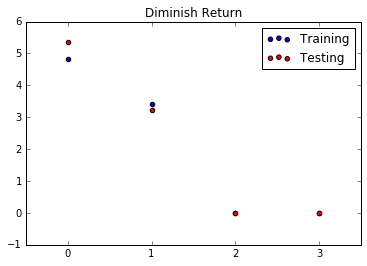

In [52]:
train_r = np.zeros(4)
test_r = np.zeros(4)
feature_set = set(np.arange(4))
train_err,test_err=lr(feature_set,train_X,train_y,test_X,test_y)
print train_err,test_err
for i,s in enumerate(feature_set):
    feature_set.remove(s)
    train_err1,test_err1=lr(feature_set,train_X,train_y,test_X,test_y)
    train_r[i] = train_err1-train_err
    test_r[i] = test_err1-test_err
    feature_set.add(s)
print train_r
plt.scatter(np.arange(4),train_r,label='Training')
plt.scatter(np.arange(4),test_r,label = 'Testing',c = 'red')
plt.xticks(np.arange(4),np.arange(4))
plt.title('Diminish Return')
plt.legend()
plt.show()

#### Remove feature according to the diminish return

0.248269115579 0.23740223296


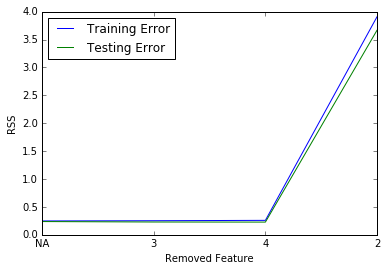

In [53]:
rm_order = np.argsort(train_r)
lr_train_err = np.zeros(4)
lr_test_err = np.zeros(4)
feature_set = set(np.arange(4))
train_err,test_err=lr(feature_set,train_X,train_y,test_X,test_y)
print train_err,test_err
lr_train_err[0] = train_err
lr_test_err[0] = test_err
for i,s in enumerate(rm_order[:-1]):
    feature_set.remove(s)
    train_err,test_err=lr(feature_set,train_X,train_y,test_X,test_y)
    lr_train_err[i+1] = train_err 
    lr_test_err[i+1] = test_err
plt.plot(np.arange(4),lr_train_err,label='Training Error')
plt.plot(np.arange(4),lr_test_err,label = 'Testing Error')
plt.xticks(np.arange(4),np.hstack(['NA',rm_order+1]))
plt.xlabel('Removed Feature')
plt.ylabel('RSS')
plt.legend(loc='best')
plt.show()

#### Lasso

In [54]:
# Data generation
# Xi ~ Ber(n,pi)

probs = np.array([0.5,0.4,0.6,0.4,0.7,0.3])
n = 10**5
s = 0
f = 0
for i,k in enumerate(itertools.product([0,1],repeat=len(probs))):
    l = np.prod(probs**np.array(k))*np.prod((1-probs)**(1-np.array(k)))*n+1e-6
    f+=l
    l = int(l)
    s+=l
    if i==0:X = np.tile(np.array(k),(l,1))
    else:X = np.vstack([X,np.tile(np.array(k),(l,1))])
print X.shape
X = X[np.random.permutation(n)]

beta = np.random.randn(4,2)*2
y = np.zeros(n)
for i in range(n):
    if X[i][0]==0:
        if X[i][1]==0: y[i] = sum(beta[0][:2]*X[i][:2])+beta[0][1]
        else: y[i] = sum(beta[1][:2]*X[i][:2])+beta[1][1]
    else:
        if X[i][1]==0: y[i] = sum(beta[2][:2]*X[i][:2])+beta[2][1]
        else: y[i] = sum(beta[3][:2]**X[i][:2])+beta[3][1]
# add noise e~N(0,0.5^2)
y = y+np.random.randn(n)*0.5
train_X = X#[:int(n*0.8)]
test_X = X#[int(n*0.8):]
train_y = y#[:int(n*0.8)]
test_y = y#[int(n*0.8):]


(100000, 6)


#### Correlated Moderator
$$\text{Marginal Distribution }p(X_1 = 1) = 0.5, p(X_2 = 1) = 0.5,$$
Joint Distribution
$$p(X_2=0|X_1=0) = 0.2, p(X_2=1|X_1=0) = 0.8$$
$$p(X_2=0|X_1=1) = 0.8, p(X_2=1|X_1=1) = 0.2$$
$$\rho = \frac{E[X_1X_2]-E[X_1]E[X_2]}{\sqrt{Var(X_1)Var(X_2)}}=\frac{0.1-0.25}{0.25}=-0.6$$

In [56]:
n = 1000
# Generate correlated X1,X2
x1 = np.zeros(n)
x1[n/2:] = 1
x2 = np.zeros(n)
#x2=1|x1=0
x2[int(n/2*0.2+1e-6):n/2] = 1
#x2=1|x1=1
x2[-int(n/2*0.2+1e-6):] = 1
Y = np.hstack([x1.reshape(-1,1),x2.reshape(-1,1)])
Y = Y[np.random.permutation(n)]
print 'Cov',np.corrcoef(Y[:,0],Y[:,1])
probs = [0.5,0.5]
X = np.zeros((n,2))
for i,p in enumerate(probs):
    X[:,i]=np.array([np.random.binomial(1,p) for j in range(n)])
X = np.hstack([Y,X])
cp = np.copy(X[:,2])
X[:,2] = X[:,1]
X[:,1] = cp
z = np.random.randn(n).reshape(n,1)
y = np.zeros(n)
beta = np.random.randn(4,2)*2
print beta
X = np.hstack([X,z])

Cov [[ 1.  -0.6]
 [-0.6  1. ]]
[[ 0.6929647  -2.33598896]
 [ 1.92435396 -0.94729992]
 [-1.2870602  -2.18208879]
 [-1.56113769 -0.43904573]]


In [57]:
# y = z*beta_0+beta_1

for i in range(n):
    if X[i][0]==0:
        if X[i][1]==0: y[i] = beta[0][0]*z[i]+beta[0][1]
        else: y[i] = beta[1][0]*z[i]+beta[1][1]
    else:
        if X[i][1]==0: y[i] = beta[2][0]*z[i]+beta[2][1]
        else: y[i] = beta[3][0]*z[i]+beta[3][1]
# add noise
print X.shape,beta
y = y+np.random.randn(n)*0.5
train_X = X[:int(n*0.8+1e-6)]
train_y = y[:int(n*0.8+1e-6)]
test_X = X[int(n*0.8+1e-6):]
test_y = y[int(n*0.8+1e-6):]

(1000, 5) [[ 0.6929647  -2.33598896]
 [ 1.92435396 -0.94729992]
 [-1.2870602  -2.18208879]
 [-1.56113769 -0.43904573]]


0.26335633393 0.212947479712
[ 1.16875883  0.78775497  0.0032449   0.0043464 ]


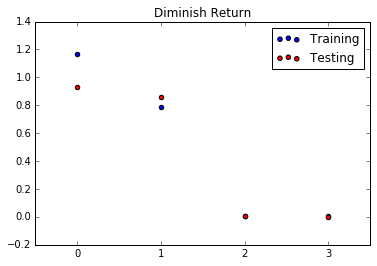

In [58]:
train_r = np.zeros(4)
test_r = np.zeros(4)
feature_set = set(np.arange(4))
train_err,test_err=lr(feature_set,train_X,train_y,test_X,test_y)
print train_err,test_err
for i,s in enumerate(feature_set):
    feature_set.remove(s)
    train_err1,test_err1=lr(feature_set,train_X,train_y,test_X,test_y)
    train_r[i] = train_err1-train_err
    test_r[i] = test_err1-test_err
    feature_set.add(s)
print train_r
plt.scatter(np.arange(4),train_r,label='Training')
plt.scatter(np.arange(4),test_r,label = 'Testing',c = 'red')
plt.xticks(np.arange(4),np.arange(4))
plt.title('Diminish Return')
plt.legend()
plt.show()

0.26335633393 0.212947479712
1.43211516376 1.14579434981
1.05111130667 1.07233180643
0.266601238568 0.216213994581
0.267702733387 0.211161157683
[ 1.43211516  1.05111131  0.26660124  0.26770273]


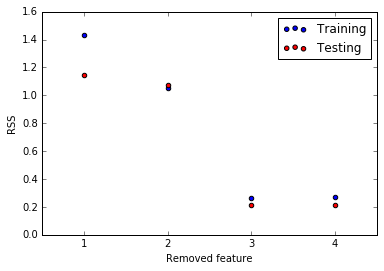

In [59]:
train_r = np.zeros(4)
test_r = np.zeros(4)
feature_set = set(np.arange(4))
train_err,test_err=lr(feature_set,train_X,train_y,test_X,test_y)
print train_err,test_err
for i,s in enumerate(feature_set):
    feature_set.remove(s)
    train_err1,test_err1=lr(feature_set,train_X,train_y,test_X,test_y)
    print train_err1,test_err1
    train_r[i] = train_err1
    test_r[i] = test_err1
    feature_set.add(s)
print train_r
plt.scatter(np.arange(4),train_r,label='Training')
plt.scatter(np.arange(4),test_r,label = 'Testing',c = 'red')
plt.xticks(np.arange(4),np.arange(4)+1)
plt.xlabel('Removed feature')
plt.ylabel('RSS')
plt.legend()
plt.show()

0.26335633393 0.212947479712
0.26335633393 0.212947479712
set([1, 2, 3]) 1.43211516376 1.14579434981
set([0, 2, 3]) 1.05111130667 1.07233180643
set([0, 1, 3]) 0.266601238568 0.216213994581
set([0, 1, 2]) 0.267702733387 0.211161157683
set([1, 3]) 2.35985878797 2.01139569955
set([0, 3]) 1.06326454506 1.08489099308
set([0, 1]) 0.269452145269 0.213677224458
set([1]) 2.42218978944 2.01390096286
set([0]) 1.06825059626 1.06381423394
[ 0.0032449   0.00285091  0.79879845] [ 2.  3.  1.]


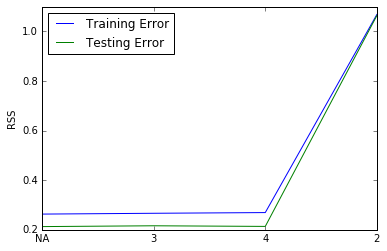

In [60]:
train_r = np.zeros(4)
test_r = np.zeros(4)
r = np.zeros(3)
feature_set = set(np.arange(4))
train_err,test_err=lr(feature_set,train_X,train_y,test_X,test_y)
print train_err,test_err
print train_err,test_err
train_r[0] = train_err
test_r[0] = test_err
removed = np.zeros(3)
for i in range(3):
    dr = 100
    f = 0
    for s in feature_set:
        feature_set.remove(s)
        train_err,test_err=lr(feature_set,train_X,train_y,test_X,test_y)
        print feature_set,train_err,test_err
        if train_err-train_r[i]<dr: 
            dr = train_err-train_r[i]
            train_r[i+1] = train_err
            test_r[i+1] = test_err
            f = s;
        feature_set.add(s)
    r[i] = train_r[i+1]-train_r[i]
    feature_set.remove(f)
    removed[i]=f
print r,removed
plt.plot(np.arange(4),train_r,label='Training Error')
plt.plot(np.arange(4),test_r,label = 'Testing Error')
plt.xticks(np.arange(4),np.hstack(['NA',rm_order+1]))
plt.ylabel('RSS')
plt.legend(loc='best')
plt.show()

In [61]:
probs = np.array([0.5, 0.4, 0.6, 0.4])
n = 1000
for i,k in enumerate(itertools.product([0,1],repeat=len(probs))):
    l = np.prod(probs**np.array(k))*np.prod((1-probs)**(1-np.array(k)))*n+1e-6
    l = int(l)
    if i==0:X = np.tile(np.array(k),(l,1))
    else:X = np.vstack([X,np.tile(np.array(k),(l,1))])

X = X[np.random.permutation(n)]

z = np.random.randn(n).reshape(n,1)
y = np.zeros(n)
beta = np.random.randn(4,2)*2
print beta
X = np.hstack([X,z])
# y = z*beta_0+beta_1

for i in range(n):
    if X[i][0]==0:
        if X[i][1]==0: y[i] = beta[0][0]*z[i]+beta[0][1]
        else: y[i] = beta[1][0]*z[i]+beta[1][1]
    else:
        if X[i][1]==0: y[i] = beta[2][0]*z[i]+beta[2][1]
        else: y[i] = beta[3][0]*z[i]+beta[3][1]
# add noise
print X.shape,beta
y = y+np.random.randn(n)*0.5
train_X = X[:int(n*0.8)]
train_y = y[:int(n*0.8)]
test_X = X[int(n*0.8):]
test_y = y[int(n*0.8):]


[[ 0.45733536 -0.95097483]
 [ 3.28380114 -0.01462054]
 [-0.96259803  0.3387922 ]
 [-1.43835987 -0.19374258]]
(1000, 5) [[ 0.45733536 -0.95097483]
 [ 3.28380114 -0.01462054]
 [-0.96259803  0.3387922 ]
 [-1.43835987 -0.19374258]]


In [62]:
def inter_terms(n,X):
    inds = list(itertools.product([0,1],repeat=n))
    ind_term = np.array(['Z'+str(i+1) for i in range(n)])
    terms = ['Z1','Z2','Z3','Z4','X']
    for i in inds:
        if i==(0,0,0,0):continue;
        terms.append(''.join(ind_term[np.nonzero(np.array(i))[0]]))    
        Xprod = np.prod(X[:,np.nonzero(np.array(i))[0]],axis=1)
        Xprod = Xprod*X[:,-1]
        X = np.hstack([X,Xprod.reshape(-1,1)])
    return X,terms[5:]
train_X,terms = inter_terms(4,train_X)
test_X,terms = inter_terms(4,test_X)
print train_X.shape,terms
print train_X[0]


(800, 20) ['Z4', 'Z3', 'Z3Z4', 'Z2', 'Z2Z4', 'Z2Z3', 'Z2Z3Z4', 'Z1', 'Z1Z4', 'Z1Z3', 'Z1Z3Z4', 'Z1Z2', 'Z1Z2Z4', 'Z1Z2Z3', 'Z1Z2Z3Z4']
[ 0.          0.          1.          1.          0.46088046  0.46088046
  0.46088046  0.46088046  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.        ]


10


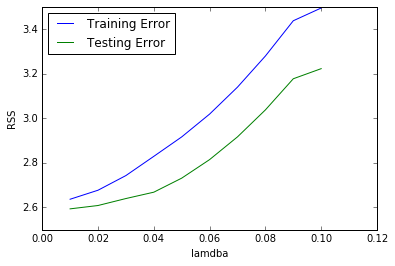

['Z4' 'Z3' 'Z3Z4' 'Z2' 'Z2Z4' 'Z2Z3' 'Z2Z3Z4' 'Z1' 'Z1Z4' 'Z1Z3' 'Z1Z3Z4'
 'Z1Z2' 'Z1Z2Z4' 'Z1Z2Z3' 'Z1Z2Z3Z4']
20
15
['Z4' 'Z3' 'Z2' 'Z2Z4' 'Z2Z3' 'Z2Z3Z4' 'Z1' 'Z1Z4' 'Z1Z3' 'Z1Z2Z4']
20
15
['Z4' 'Z3' 'Z2' 'Z2Z4' 'Z2Z3' 'Z2Z3Z4' 'Z1' 'Z1Z4' 'Z1Z2Z4' 'Z1Z2Z3'
 'Z1Z2Z3Z4']
20
15
['Z4' 'Z3' 'Z2' 'Z2Z4' 'Z2Z3' 'Z1Z4' 'Z1Z3' 'Z1Z3Z4' 'Z1Z2' 'Z1Z2Z4']
20
15
['Z4' 'Z3' 'Z2' 'Z2Z4' 'Z2Z3' 'Z1Z4' 'Z1Z3' 'Z1Z3Z4' 'Z1Z2Z4' 'Z1Z2Z3']
20
15


IndexError: index 15 is out of bounds for axis 1 with size 15

In [63]:
alphas = np.linspace(0.01,0.1,10)
train_err = []
test_err = []
coeffs = []
for a in alphas:
    model = linear_model.Lasso(alpha=a)
    model.fit(train_X,train_y)
    train_err.append(np.mean((model.predict(train_X)-train_y)**2))
    test_err.append(np.mean((model.predict(test_X)-test_y)**2))    
    coeffs.append(model.coef_)
print len(coeffs)

plt.plot(alphas,train_err,label = 'Training Error')
plt.plot(alphas,test_err,label='Testing Error')
plt.legend(loc='best')
plt.xlabel('lamdba')
plt.ylabel('RSS')
plt.show()
terms = np.array(terms)
print terms
for coeff in coeffs:
    print (len(coeff))
    print len(terms)
    print terms[np.nonzero(coeff)[0]]